In [54]:
#Librerías necesarias
import yfinance as yf #para obtener los retornos historicos
import pandas as pd   #para trabajar bases de datos
import cvxpy as cp    # alternativo a gurobi, este es gratis y con pocas variables no hay problemas
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Primero un ejemplo para ilustrar, recordar y aprender comandos y librerias
# Descarga los datos históricos
#establecer fechas inicio y final
inicio = "2015-01-01"
final  = "2023-12-31"
ticker = "AAPL"  # Reemplaza con el ticker de tu acción
data = yf.download(ticker, start=inicio, end=final)
# Resamplear los datos a fin de mes usando el precio ajustado (Adj Close)
#------------------------------------------------------------------------------------------------------------------------------#
#Precio cierre mensual
monthly_data = data['Close'].resample('M').last() 
# 'Close' es el nombre de la columna, y resample elige el ultimo dato del mes 
#recordar que hay fines de mes feriados o domingos etc,
#------------------------------------------------------------------------------------------------------------------------------#
#Luego para los retornos mensuales
monthly_return=monthly_data.pct_change()

[*********************100%***********************]  1 of 1 completed
C:\Users\julio\AppData\Local\Temp\ipykernel_10760\3947727178.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = data['Close'].resample('M').last()


In [5]:
#Ahora con un vector de tickers, ejemplo en acciones chilenas
tickers = ["SQM", "AGUAS-A.SN", "FALABELLA.SN", "BSAC", "COPEC.SN"]
n_tic=len(tickers)
retornos= pd.DataFrame()
inicio = "2020-01-01"
final  = "2024-11-30"
for i in range(n_tic):
    print(i)
    data = yf.download(tickers[i], start=inicio, end=final)
    monthly_data = data['Close'].resample('M').last() 
    monthly_return=monthly_data.pct_change()
    retornos[tickers[i]]=monthly_return
    
retornos = retornos.dropna()


0


[*********************100%***********************]  1 of 1 completed
C:\Users\julio\AppData\Local\Temp\ipykernel_10760\2960067583.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = data['Close'].resample('M').last()


1


[*********************100%***********************]  1 of 1 completed
C:\Users\julio\AppData\Local\Temp\ipykernel_10760\2960067583.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = data['Close'].resample('M').last()


2


[*********************100%***********************]  1 of 1 completed
C:\Users\julio\AppData\Local\Temp\ipykernel_10760\2960067583.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = data['Close'].resample('M').last()


3


[*********************100%***********************]  1 of 1 completed
C:\Users\julio\AppData\Local\Temp\ipykernel_10760\2960067583.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = data['Close'].resample('M').last()


4


[*********************100%***********************]  1 of 1 completed
C:\Users\julio\AppData\Local\Temp\ipykernel_10760\2960067583.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = data['Close'].resample('M').last()


In [6]:
retornos.to_excel("retornos.xlsx", sheet_name="Monthly Data")

print("El archivo 'monthly_data.xlsx' se ha guardado correctamente.")

El archivo 'monthly_data.xlsx' se ha guardado correctamente.


In [7]:
r_e=pd.DataFrame()
cov=retornos.cov()
for i in range(n_tic):
    r=retornos[tickers[i]].mean()
    r_e[tickers[i]]=[r]

### El problema de minimización de Markowitz
### Sea $w_i$ los pesos del activo i (ticker in tickers), tal que $\sum_{i=1}^n w_i = 1$
### La varianza de un portafolio se define matricialmente como $\sigma_p^2 = w^T \Sigma w$, donde  $\Sigma$ es la matriz de covarianza
###
### Finalmente el problema a resolver es el siguiente:
$$
\begin{aligned}
\min_{w} & \quad w^T \Sigma w \\
\text{st:} & \quad \sum_{i=1}^n w_i =1, \\
& \quad \sum_{i=1}^n E[R_i]w_i\geq R^*, \\
& \quad w_i \geq 0.
\end{aligned}
$$


In [44]:
R=r_e.iloc[0].values
w = cp.Variable(n_tic)
R_obj=0.018 # para construir la frontera eficiente se necesita un vector de retornos
f_obj=cp.Minimize(cp.quad_form(w,cov.values))
restricciones=[
    cp.sum(w)==1,
    R @ w >= R_obj,
    w>=0]
problem = cp.Problem(f_obj, restricciones)
problem.solve()

# Resultados
print("Status:", problem.status)  # Debería ser 'optimal'
print("Para R%:", np.round(R_obj*100,4))
print("Pesos óptimos %:", np.round(w.value*100,2))  # Pesos del portafolio
print("Varianza mínima:", problem.value)  # Varianza mínima
print("Volatilidad mínima %:",np.round(np.sqrt(problem.value)*100,2))

Status: optimal
Para R%: 1.8
Pesos óptimos %: [92.16  7.84 -0.   -0.   -0.  ]
Varianza mínima: 0.017146458993389797
Volatilidad mínima %: 13.09


In [52]:
R_min=0
R_max=0.018
vector_R= np.linspace(R_min, R_max, 20)


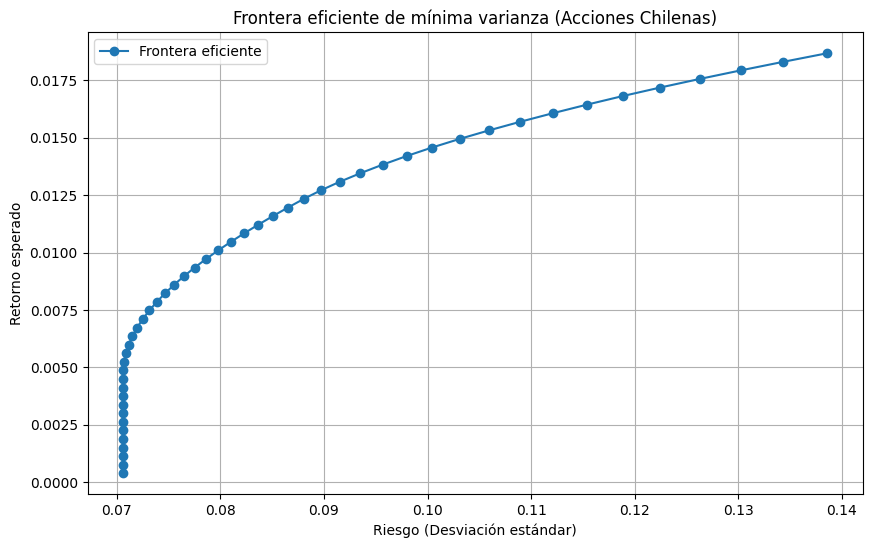

In [55]:
# Asegúrate de tener las matrices y vectores necesarios
mu = r_e.iloc[0].values  # Retornos esperados de los activos (promedio)
Sigma = retornos.cov()   # Matriz de covarianza de los retornos

# Número de activos
n = len(tickers)

# Definir el rango de retornos objetivo
R_min, R_max = mu.min(), mu.max()
R_targets = np.linspace(R_min, R_max, 50)  # 50 valores entre el mínimo y máximo de los retornos

# Listas para almacenar los riesgos (desviación estándar) y retornos
risks = []
returns = []

# Optimización para cada valor de retorno objetivo
for R_target in R_targets:
    w = cp.Variable(n)
    objective = cp.Minimize(cp.quad_form(w, Sigma))  # Función objetivo: minimizar la varianza
    constraints = [
        cp.sum(w) == 1,            # La suma de los pesos debe ser igual a 1
        mu @ w >= R_target,        # El retorno del portafolio debe ser mayor o igual a R_target
        w >= 0                     # No hay posiciones cortas (pesos no negativos)
    ]
    problem = cp.Problem(objective, constraints)
    problem.solve()  # Resolver el problema de optimización
    
    # Si el problema es factible, añadir el riesgo (desviación estándar) y el retorno
    if problem.status == 'optimal':
        risks.append(np.sqrt(problem.value))  # Riesgo (desviación estándar)
        returns.append(R_target)
    else:
        risks.append(np.nan)  # Si no es factible, añadir NaN
        returns.append(np.nan)

# Graficar la frontera eficiente
plt.figure(figsize=(10, 6))
plt.plot(risks, returns, marker='o', label="Frontera eficiente")
plt.xlabel("Riesgo (Desviación estándar)")
plt.ylabel("Retorno esperado")
plt.title("Frontera eficiente de mínima varianza (Acciones Chilenas)")
plt.legend()
plt.grid(True)
plt.show()